In [65]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import numpy as np
import glob
import os
import pylidc as pl
import pydicom
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [66]:
class Dataset(BaseDataset):
    def __init__(self, split='train'):
        img_list, mask_list = self.excute()
#         img_list, mask_list = shuffle(img_list, mask_list, random_state = 1)
        train_len = int(len(img_list) * 0.8) # 訓練データ
        val_len = int(len(img_list) * 0.1) # 検証データ
        test_len = int(len(img_list) - train_len - val_len) # テストデータ
        if split == 'train':
            self.img_list, self.mask_list = img_list[:train_len], mask_list[:train_len]
        elif split == 'val':
            self.img_list, self.mask_list = img_list[train_len:train_len + val_len], mask_list[train_len:train_len + val_len]
        elif split == 'test':
            self.img_list, self.mask_list = img_list[train_len + val_len:], mask_list[train_len + val_len:]


    # 任意のtextureの値のあるアノテーションデータを全て取り出す
    def get_texture(self, texture_val):
        return pl.query(pl.Annotation).filter(pl.Annotation.texture <= texture_val).all()

    # アノテーション情報を入れると，そのアノテーションに対するスキャンデータを取り出す Annotation -> Scan
    def get_scan(self, annotation):
        return (pl.query(pl.Scan).filter(pl.Scan.id == annotation.scan_id)).all()

    # アノテーションされたデータのアノテーション部分を取り出す Annotation -> Contour
    def get_contour(self, annotation):
        return pl.query(pl.Contour).filter(pl.Contour.annotation_id == annotation.id).all()

    # スキャンデータに対するdicomのパスを取り出す
    def get_abs_path(self, scan):
        return scan[0].get_path_to_dicom_files() + '/'

    # アノテーションされたデータのスライス面のリストを返す
    def get_contour_slice_list(self, contour):
        contour_slice_list = []
        contour_matrix_list = []
        for index in range(len(contour)):
            contour_slice = contour[index].image_k_position
            contour_slice_list.append(contour_slice)
            contour_matrix = contour[index].to_matrix(False)
            contour_matrix_list.append(contour_matrix)
        return contour_slice_list, contour_matrix_list

    # 目標のdicomファイルを取り出す
    def get_dicom_path(self, dir_name, contour_slice):
        all_dicom_count = len(glob.glob(dir_name + '*.dcm'))
        # スライス面とdcmが反対から参照のためファイル総数からスライス面を引く
        target_dicom_num = all_dicom_count - contour_slice 
        target_dicom = glob.glob(dir_name + '*{}*.dcm'.format(str(target_dicom_num)))[0]
        return target_dicom_num, target_dicom

    # dicomのCT値を取り出す
    def get_ct_vol(self, dicom_path):
        ds = pydicom.dcmread(dicom_path)
        return ds.pixel_array

    def to_mask(self, ct_vol, contour_matrix):
        mask = np.zeros(ct_vol.shape, dtype=np.int32)
        cv2.fillConvexPoly(mask, points=contour_matrix[:,::-1], color=(1))
        return mask

    def __getitem__(self, index):
        return {
                'img': self.img_list[index],
                'mask': self.mask_list[index]
                }
    
    def __len__(self):
        return len(self.img_list)

    # 実行
    def excute(self):
        ann_index = 0
        i = 1012 # 1012
        img_list = []
        mask_list = []
        for ann_index in range(len(self.get_texture(1))):
            annotation = (self.get_texture(1))[ann_index]
            scan = self.get_scan(annotation)
            dir_name = self.get_abs_path(scan)
            contour_slice_list, contour_matrix_list = self.get_contour_slice_list(self.get_contour(annotation))
            contour = self.get_contour(annotation)

            for contour_slice, contour_matrix in zip(contour_slice_list, contour_matrix_list):
                target_dicom_num, target_dicom = self.get_dicom_path(dir_name, contour_slice)
                ct_vol = self.get_ct_vol(target_dicom)
                mask = self.to_mask(ct_vol, contour_matrix)
                img_list.append(ct_vol) 
                mask_list.append(mask)
        return img_list, mask_list

In [67]:
d = Dataset()

In [69]:
i = 1
data = d[i]

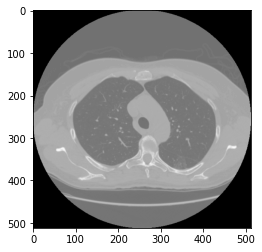

In [63]:
plt.imshow(data['img'], cmap="gray")

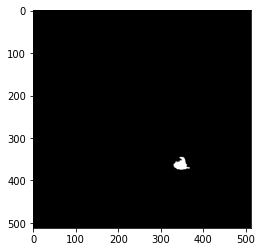

In [64]:
plt.imshow(data['mask'], cmap="gray")